# Informe Final Carrera
Profundiza y ajusta la resolución de tus proyectos: agrega al menos una fuente de datos o prueba un modelo que hasta el momento no hayas aplicado. Elabora un informe ?nal que describa el proceso de toma de decisiones. Sustenta la razón por la cual usaste las librerías y aplicaste los métodos al dataset. Todos tus hallazgos deberán ser comunicados en función de la problemática y las preguntas que buscabas responder.

## Banksim dataset

Detectaremos las transacciones fraudulentas del conjunto de datos de Banksim. Este **conjunto de datos generado sintéticamente** consiste en pagos de varios clientes hechos en diferentes períodos de tiempo y con diferentes cantidades. Para más información sobre el conjunto de datos, puede consultar la página de [Kaggle](https://www.kaggle.com/ntnu-testimon/banksim1) para este conjunto de datos que también tiene el enlace al documento original.  

Los pasos a seguir en el presente estudio, serán los siguientes:

1. Exploratory Data Analysis (EDA)
2. Data Preprocessing
3. Modelos de Machine Learning
4. Clustering
5. Oversampling with SMOTE
6. Mejor Modelo Elegido, una vez aplicado SMOTE
7. Conclusión
8. Recursos

### 1. Análisis Exploratorio de Datos

1. __Se importan las librerías__ necesarias para trabajar en la consigna.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

2. __Se realiza la carga el dataset__ usando las funcionalidades de Pandas.

In [2]:
banksim = pd.read_csv('bs140513_032310.csv')

In [3]:
banksim.shape

(594643, 10)

* *El Dataset, cuenta con **594.643 Filas**, y **10 Columnas**.*

In [4]:
banksim.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


3. Se realiza una __descripción__ de las características:  

* *Step:* Representa el día desde el comienzo de la simulación. Tiene 180 pasos, por lo que la simulación dura virtualmente 6 meses.  
* *Customer:* Representa la identificación del cliente.  
* *zipCodeOrigin:* El código postal de origen/fuente.  
* *Merchant:* La identificación del comerciante.  
* *zipMerchant:* El código postal del comerciante.  
* *Edad:* Edad categorizada, las cuales se detallan a continuación:  
    * 0: <= 18,  
    * 1: 19-25,  
    * 2: 26-35,  
    * 3: 36-45,  
    * 4: 46-55,  
    * 5: 56-65,  
    * 6: > 65  
    * U: Desconocido  
* *Gender:* Género para el cliente.  
    * E : Enterprise,  
    * F: Mujer,  
    * M: Hombre,  
    * U: Desconocido  
* *Category:* Categoría de la compra. A posteriori se verán con más detalle.  
* *Amount:* Cantidad de la compra.  
* *Fraud:* Variable objetivo que muestra si la transacción es fraudulenta(1) o no (0).

4. __Info por Columna:__ Se imprimen los nombres de cada columna, a qué tipo de dato corresponden y sus valores faltantes.

In [5]:
banksim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


* *Ninguna columna tiene valores faltantes, lo cual es lógico por tratarse de un dataset sintético.*
* *Por ello, es que no será necesario realizar imputación de valores.*

5. Análisis del feature **Fraude**.

* *Los datos de los fraudes estarán desequilibrados como se ve en el gráfico de abajo y en el recuento de instancias.*  
* *Para equilibrar el conjunto de datos se pueden realizar técnicas de sobremuestreo o submuestreo.*  
* *El sobremuestreo es aumentar el número de la clase minoritaria generando instancias de la clase minoritaria.*  
* *El submuestreo consiste en reducir el número de instancias de la clase mayoritaria mediante la selección de puntos aleatorios de la misma hasta que sea igual a la clase minoritaria.*  
* *Ambas operaciones tienen algunos riesgos: El sobremuestreo creará copias o puntos de datos similares que a veces no serían útiles para el caso de la detección de fraudes porque las transacciones fraudulentas pueden variar. El submuestreo significa que perdimos puntos de datos y, por lo tanto, información.*  
* *En el presente análisis, realizaremos una técnica de sobremuestreo llamada SMOTE (técnica de sobremuestreo de minorías sintéticas).*  
* *SMOTE creará nuevos puntos de datos de la clase minoritaria utilizando las instancias vecinas, de modo que las muestras generadas no son copias exactas, sino que son similares a las instancias que tenemos.*

In [6]:
pd.unique(banksim['fraud'])

array([0, 1], dtype=int64)

Text(0.5, 1.0, 'Número de Customers')

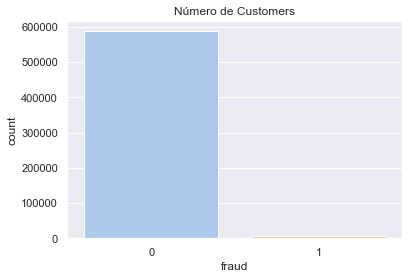

In [7]:
sns.countplot(data = banksim, x = 'fraud', order = banksim['fraud'].value_counts().index, palette='pastel')
plt.title('Número de Customers')

In [8]:
print(banksim['fraud'].value_counts().sum())

594643


In [9]:
print(banksim['fraud'].value_counts())

0    587443
1      7200
Name: fraud, dtype: int64


* *Vemos que las instancias con fraude representan un 98,8% del total, pudiendo corroborarse el desbalanceo del dataset.*

6. Análisis del feature **Fraude por Categoría**.

In [10]:
pd.unique(banksim['category'])

array(["'es_transportation'", "'es_health'", "'es_otherservices'",
       "'es_food'", "'es_hotelservices'", "'es_barsandrestaurants'",
       "'es_tech'", "'es_sportsandtoys'", "'es_wellnessandbeauty'",
       "'es_hyper'", "'es_fashion'", "'es_home'", "'es_contents'",
       "'es_travel'", "'es_leisure'"], dtype=object)

In [11]:
print(banksim['category'].value_counts())

'es_transportation'        505119
'es_food'                   26254
'es_health'                 16133
'es_wellnessandbeauty'      15086
'es_fashion'                 6454
'es_barsandrestaurants'      6373
'es_hyper'                   6098
'es_sportsandtoys'           4002
'es_tech'                    2370
'es_home'                    1986
'es_hotelservices'           1744
'es_otherservices'            912
'es_contents'                 885
'es_travel'                   728
'es_leisure'                  499
Name: category, dtype: int64


* *Además, podemos ver la cantidad media y el porcentaje de fraude por categoría a continuación.*
* *Parece que el **ocio y los viajes son las categorías más seleccionadas por los defraudadores**.*
* *Los defraudadores eligieron las categorías en las que la gente gasta más en promedio. Confirmemos esta hipótesis comprobando la cantidad de fraude y de no fraude que se ha tramitado.*

In [12]:
print("Cantidad media y porcentaje por categoriaa",banksim.groupby('category')['amount','fraud'].mean())

Cantidad media y porcentaje por categoriaa                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


<ipython-input-12-e747060d8e56>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print("Cantidad media y porcentaje por categoriaa",banksim.groupby('category')['amount','fraud'].mean())


7. Análisis de los features **Fraude por Monto o Gasto**.

In [13]:
banksim[['amount']].describe().round()

,amount
count,594643.0
mean,38.0
std,111.0
min,0.0
25%,14.0
50%,27.0
75%,43.0
max,8330.0


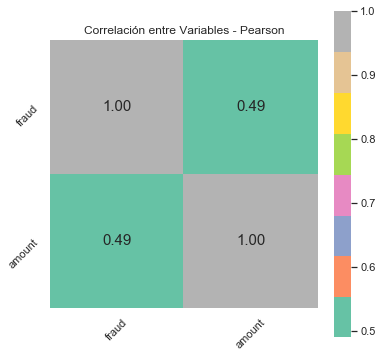

In [14]:
corr = banksim[['fraud','amount']].corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, cmap= 'Set2')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('Correlación entre Variables - Pearson')
plt.show()

* *Como vemos en el cuadro siguiente, podemos decir que en una transacción fraudulenta, será mucho mayor el monto o gasto (`amount`) -unas cuatro veces o más-, que el monto o gasto promedio para dicha categoría.*

In [15]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = banksim.loc[banksim.fraud == 1] 
df_non_fraud = banksim.loc[banksim.fraud == 0]

In [16]:
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           banksim.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000
'es_sportsandtoys',345.366811,88.502738,49.525237


* *Las categorías de gasto promedio son similares; entre 0-500 descartando los valores atípicos, excepto la categoría de viajes, que es muy alta.*

No handles with labels found to put in legend.


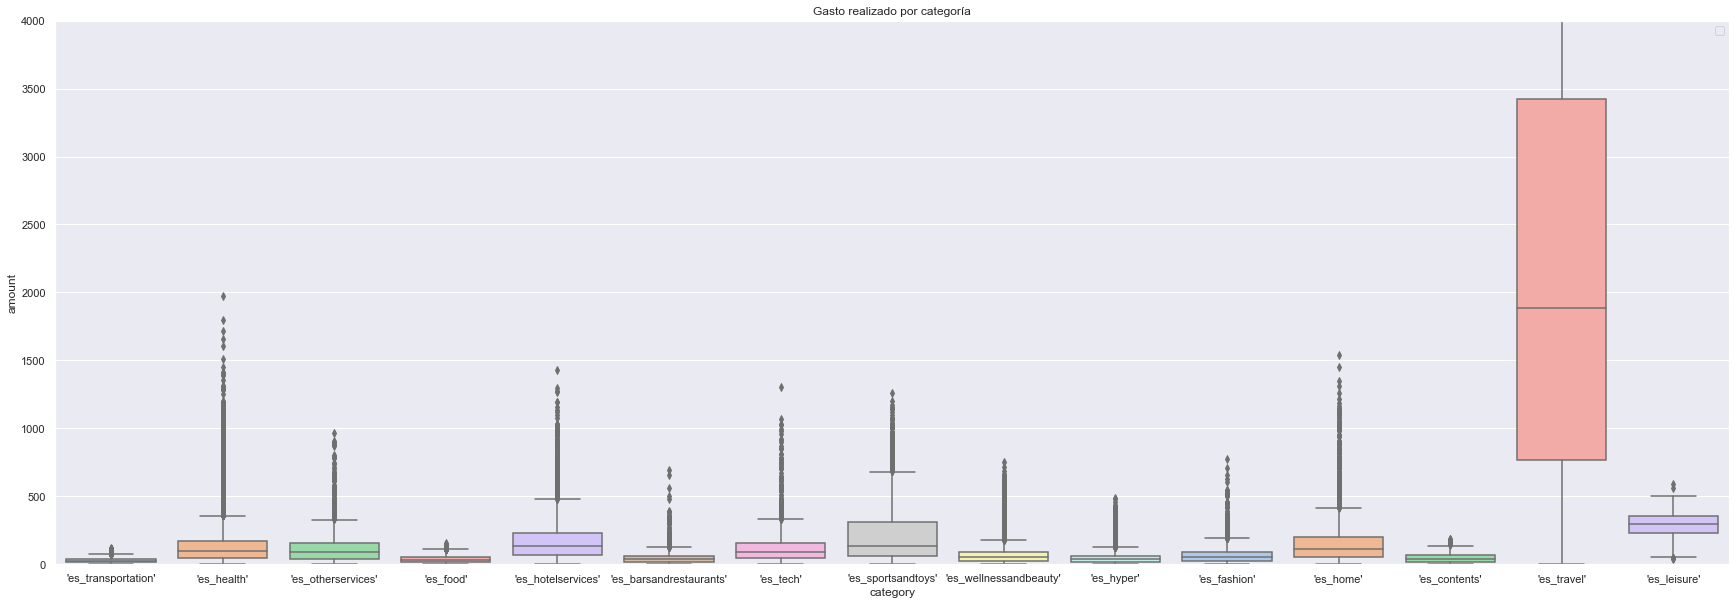

In [17]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30,10))
sns.boxplot(data = banksim, x = 'category', y = 'amount', palette='pastel')
plt.title("Gasto realizado por categoría")
plt.ylim(0,4000)
plt.legend()
plt.show()

* *Una vez más podemos ver en el histograma de abajo que las transacciones fradulentas son menos en cantidad pero más en monto.*

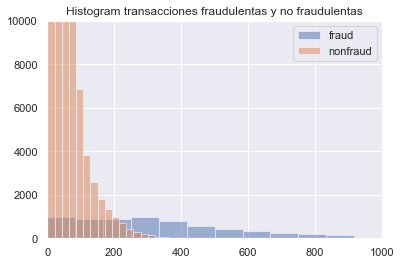

In [18]:
plt.hist(data = df_fraud, x = 'amount', alpha=0.5, label='fraud',bins=100)
plt.hist(data = df_non_fraud, x = 'amount', alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram transacciones fraudulentas y no fraudulentas")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

* *Con montos mayores a 400, ya poderíamos decir que hay fraude.*

8. Análisis de los features **Fraude por Edad**.

In [19]:
pd.unique(banksim['age'])

array(["'4'", "'2'", "'3'", "'5'", "'1'", "'6'", "'U'", "'0'"],
      dtype=object)

In [20]:
print(banksim['age'].value_counts())

'2'    187310
'3'    147131
'4'    109025
'5'     62642
'1'     58131
'6'     26774
'0'      2452
'U'      1178
Name: age, dtype: int64


* *Parece que **el fraude ocurre más en edades iguales y menores de 18 años (0º categoría)**. ¿Puede ser debido a que los estafadores piensan que habría menos consecuencias si muestran su edad más joven, o tal vez realmente son jóvenes.*

In [21]:
print((banksim.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


9. Análisis del feature **Customer**.

In [22]:
pd.unique(banksim['customer'])

array(["'C1093826151'", "'C352968107'", "'C2054744914'", ...,
       "'C1014783484'", "'C849065220'", "'C1809646275'"], dtype=object)

In [23]:
print(banksim['customer'].value_counts())

'C1978250683'    265
'C1275518867'    252
'C806399525'     237
'C515668508'     205
'C1338396147'    195
                ... 
'C1156745710'      6
'C1345586046'      6
'C1404665203'      5
'C1743702978'      5
'C1809646275'      5
Name: customer, Length: 4112, dtype: int64


In [24]:
#sns.countplot(data = banksim, y = 'customer', order = banksim['customer'].value_counts().index, palette='pastel')
#plt.title('Número de Customers')

10. Análisis de los features **Zip Code**.

In [25]:
print(banksim['zipcodeOri'].value_counts())

'28007'    594643
Name: zipcodeOri, dtype: int64


In [26]:
print(banksim['zipMerchant'].value_counts())

'28007'    594643
Name: zipMerchant, dtype: int64


* *Como se observa, hay un sólo tipo de Zip Code, tanto de Origen como de Comerciante, por lo que luego, en el preprocesamiento de datos, los descartaremos.*

### 2. Preprocesamiento de Datos

1. Descartamos las columnas de **Zip Code**.

In [27]:
banksim_reduced = banksim.drop(['zipcodeOri','zipMerchant'],axis=1)

In [28]:
banksim_reduced.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151','4','M','M348934600','es_transportation',4.55,0
1,0,'C352968107','2','M','M348934600','es_transportation',39.68,0
2,0,'C2054744914','4','F','M1823072687','es_transportation',26.89,0
3,0,'C1760612790','3','M','M348934600','es_transportation',17.25,0
4,0,'C757503768','5','M','M348934600','es_transportation',35.72,0


* *Vemos que se eliminaron ambos Zip Codes.*

2. __Encoders:__ Se aplicará Dummies para transformar los features con valores categóricos a enteros.

* *La elección de Encoder elegida, es porque las categorías a trabajar, son nominales, es decir que no tienen un orden.*

* *Aquí transformaremos los rasgos categóricos en valores numéricos. Normalmente es mejor convertir este tipo de valores categóricos en maniquíes porque no tienen relación en tamaño (es decir, el cliente1 no es mayor que el cliente2) pero como son demasiados (más de 500.000 clientes y comerciantes) las características crecerán 10^5 en tamaño y tardarán una eternidad en formarse.*

In [29]:
# banksim_reduced.loc[:,['customer','merchant','category']].astype('category')
#banksim_dum = pd.get_dummies(banksim_reduced.loc[:,['customer','merchant','category','gender']],drop_first=True)
#print(banksim_dum.info())

In [30]:
col_categorical = banksim_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    banksim_reduced[col] = banksim_reduced[col].astype('category')
# categorical values ==> numeric values
banksim_reduced[col_categorical] = banksim_reduced[col_categorical].apply(lambda x: x.cat.codes)
banksim_reduced.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


In [31]:
#banksim_ml = pd.concat([banksim_reduced,banksim_dum], axis = 1)
#banksim_ml.head()

### 3. Modelos de Machine Learning

1. Se **seleccionan las variables** predictoras (`X`) y la variable a predecir (`y`).

In [32]:
X = banksim_reduced[['step','customer','age','gender','merchant','category','amount']]
y = banksim_reduced[['fraud']]

2. __Train Test Split__ para dividir el entrenamiento del test.

* *Haré una prueba de tren dividida para medir el rendimiento. No he hecho la validación cruzada ya que tenemos muchas instancias y no quiero esperar tanto para entrenar pero debería ser mejor hacer la validación cruzada la mayoría de las veces.*

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42,shuffle=True,stratify=y)

3. Definiré una función para trazar la __curva ROC_AUC__. Es una buena forma visual de ver el rendimiento de la clasificación.

In [34]:
# %% Function for plotting ROC_AUC curve

def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

* *Como ya he dicho antes, los conjuntos de datos sobre el fraude estarán desequilibrados y la mayoría de los casos no serán fraudulentos. Imagina que tenemos el conjunto de datos aquí y siempre estamos prediciendo que no será fraudulento. Nuestra precisión sería de casi el 99% para este conjunto de datos y sobre todo para otros también, ya que el porcentaje de fraude es muy bajo. Nuestra precisión es muy alta pero no estamos detectando ningún fraude, así que es un clasificador inútil. Por lo tanto, la puntuación de la precisión de la base debería ser mejor al menos que la predicción de siempre no fraudulento para realizar una detección.*

#### 3.1 K-Neighbours Classifier

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

# Definimos las listas vacias para los valores de accuracy deseados
lista_accuracy_train = []
lista_accuracy_test = []

# Definimos la lista de valores de k que vamos a explorar
k_vecinos = [1,2,3,4,5,6,7,8,9,10]

# Generamos un loop sobre los distintos valores de k 
for k in k_vecinos:
    
    # Vamos a repetir el siguiente bloque de código
    
    # Definir el modelo con el valor de vecinos deseado
    clf = KNeighborsClassifier(n_neighbors= k)
    
    # Entrenar el modelo
    clf.fit(X_train, np.ravel(y_train))
    
    # Predecir y evaluar sobre el set de entrenamiento
    y_train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_true = y_train, y_pred = y_train_pred)
    
    # Predecir y evaluar sobre el set de evaluación
    y_test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_true = y_test, y_pred = y_test_pred)
    
    # Agregar la información a las listas
    lista_accuracy_train.append(train_acc)
    lista_accuracy_test.append(test_acc)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize = (8,4))
plt.plot(k_vecinos, lista_accuracy_train,'o-',label='train' )
plt.plot(k_vecinos, lista_accuracy_test,'o-',label='test')
plt.legend()
plt.xlabel("K Vecinos")
plt.ylabel("Accuracy")
plt.title('Curva de Validación - K Vecinos')

In [ ]:
print("K vecinos con máximo Accuracy para train:",k_vecinos[lista_accuracy_train.index(min(lista_accuracy_train))],"con un valor de",lista_accuracy_train[lista_accuracy_train.index(min(lista_accuracy_train))])

print("K vecinos con máximo Accuracy para test:",k_vecinos[lista_accuracy_test.index(min(lista_accuracy_test))],"con un valor de",lista_accuracy_test[lista_accuracy_test.index(min(lista_accuracy_test))])

In [ ]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)

In [ ]:
knn.feature_importances_

In [ ]:
modelo = ['KNN-Classifier']

for i, model in enumerate([regresor]):
    y_train_pred = model.predict(X_train).reshape(50358,1)
    y_test_pred = model.predict(X_test).reshape(21582,1)
    
    print(f'Modelo: {modelo[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    plt.figure(figsize = (12,5))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 25, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 25, label = 'test')
    plt.xlabel('errores')
    plt.title('Histograma de Errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    plt.title('Gráfico de Dispersión')
    
    plt.tight_layout()
    plt.show()

In [ ]:
print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])

#### 3.2. Random Forest Classifier

<ipython-input-37-ed30824103b1>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train,y_train)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    146861
           1       0.24      0.98      0.38      1800

    accuracy                           0.96    148661
   macro avg       0.62      0.97      0.68    148661
weighted avg       0.99      0.96      0.97    148661

Confusion Matrix of Random Forest Classifier: 
 [[141158   5703]
 [    31   1769]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


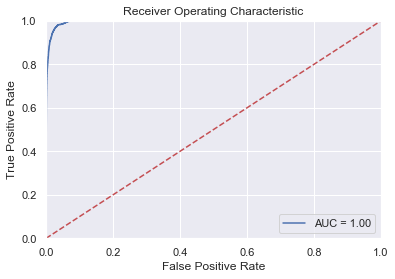

In [37]:
from sklearn.ensemble import RandomForestClassifier

# %% Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])

#### 3.3. XGBoost Classifier

In [39]:
#mport xgboost as xgb
#rom xgboost import XGBRegressor
#GBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                                #objective="binary:hinge", booster='gbtree', 
                                #n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                #subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                #scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=True)

#GBoost_CLF.fit(X_train,y_train)

#y_pred = XGBoost_CLF.predict(X_test)

#reatively high precision and recall for fraudulent class
#print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred)) # Accuracy for XGBoost:  0.9963059088641371
#print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))
#plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])

### 4. Oversampling with SMOTE

* *Usando SMOTE (Técnica de Sobremuestreo de Minorías Sintéticas) [2] para equilibrar el conjunto de datos. Los resultados muestran que ahora tenemos el número exacto de instancias de clase (1 y 0)*

In [48]:
#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(X, y)
#y_res = pd.DataFrame(y_res)
#print(y_res[0].value_counts())

* *Haré una prueba de tren dividida para medir el rendimiento. No he hecho la validación cruzada ya que tenemos muchas instancias y no quiero esperar tanto para entrenar pero debería ser mejor hacer la validación cruzada la mayoría de las veces.*

In [49]:
#from sklearn.model_selection import train_test_split
## I won't do cross validation since we have a lot of instances
##X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

### 5. Clustering

* *Se procederá a realizar la comparación de K-Means y Silhouette, con el fin de observar los resultados arrojados por cada uno de ellos, respecto a cómo se encuentran concentradas los Categorías, Gastos y Edades.*

#### 5.1. Silhouette

* *A continuación, se evalúan las particiones mediante el valor de silhouette.*
* *Al variar los parámetros de los modelos de clustering, cambiará la distribución del valor de Silhouettes en los datos. Con esa distribución, se elegirán los mejores parametros posibles (cohesión y separación).*

*__Nota 1:__ el coeficiente de Silhoutte va de -1 a 1.*

*__Nota 2:__ el Silhouette promedio también va del -1 al 1, donde en 1 los clusters están bien separados, en 0 están cerca y en -1 el los clusters están mezclados. Esto nos da una idea de cuán buena es la separación en clusters.*

* *En ésta oportunidad, vamos a calcular el valor de silhouette usando la función `silhouette_score`.*

In [35]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs, make_moons

In [33]:
X = banksim_reduced[['category']]
y = banksim_reduced[['fraud']]

In [ ]:
'step','customer','age','gender','merchant',,'amount'

In [36]:
# Preparamos una lista donde vamos a ir agregando los valores medios de silhouette
lista_sil = []
# Fiteammos un modelo para cada numero de cluster que queremos testear
for k in range(2,14):
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    
    # Tomamos las etiquetas
    etiquetas = km.labels_
    
    # Calculamos el silhouette 
    valor_medio_sil = silhouette_score(X, etiquetas)
    lista_sil.append(valor_medio_sil)
    
plt.figure(figsize = (10,7))
plt.plot(K, lista_sil, lw=3)
plt.scatter(K, lista_sil,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Silhouette Media')
plt.title('Silhouette Media por Nro. de Clusters')
plt.show()

KeyboardInterrupt: 

* *El gráfico, representa el Promedio de todas las siluetas por cantidad de clusters.*
* *Si contrastamos con la próxima gráfica de silueta, que se verá de costado, vendría a ser la línea punteada observada.*

In [ ]:
X_std = X

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
    
km = KMeans(n_clusters=8)
labels = km.fit_predict(X_std)
centroids = km.cluster_centers_

silhouette_vals = silhouette_samples(X_std, labels)

y_ticks = []
y_lower, y_upper = 0, 0
for i, cluster in enumerate(np.unique(labels)):
    cluster_silhouette_vals = silhouette_vals[labels == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
    y_lower += len(cluster_silhouette_vals)

avg_score = np.mean(silhouette_vals)
ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
ax1.set_yticks([])
ax1.set_xlim([-0.1, 1])
ax1.set_xlabel('Valores del Coeficiente de Silueta')
ax1.set_ylabel('Clusters')
ax1.set_title('Diagrama de Siluetas', y=1.02);

# Scatter plot of data colored with labels
ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels)
ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
ax2.set_xlim([-12, 12])
ax2.set_xlim([-12, 12])
ax2.set_xlabel('Tiempo de Emisión en Minutos')
ax2.set_ylabel('Tiempo de Espera p/ Próxima Emisión')
ax2.set_title('Visualización de los Clusters', y=1.02)
ax2.set_aspect('equal')
plt.tight_layout()
plt.suptitle(f'Análisis de Silueta utilizando k = {8}', fontsize=16, fontweight='semibold', y=1.05);

* *Aclaraciones del gráfico:*
    * *En el eje x está el valor de Silhouette, en el eje y los clusters.*
    * *El valor de silhouette de cada instancia está graficado como una barrita muy finita. Están todas las instancias graficadas, ordenadas de mayor a menor.*
    * *La línea punteada roja representa el Silhouette promedio de toda la partición.*
* *En éste caso, los clusters se ven bien separados, y de hecho ese es el típico gráfico buscado. Todos los coeficientes están cerca del Silhouette promedio, algunos por arriba, otros por abajo, pero no hay grandes discrepancias.*

* *Como se observa, el mejor número de Clusters para separar los `Barrios` es **k=8**, lo cual difiere de lo arrojado por K-Means (k=6)*

#### 5.2 K-Means

4.1 Se determina el **número de Clusters y Centros**.

In [41]:
n_samples = 100000
n_centros = 6
X, y = make_blobs(centers=n_centros, cluster_std=0.3, n_features=2, random_state=0)

* *Se grafican los datasets.*

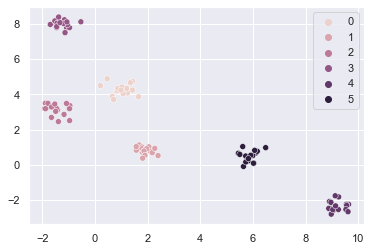

In [42]:
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y, legend ='full')
plt.show()

* *Se evaluarán las particiones a realizar mediante KMeans usando la distancia al centroide. La idea es que al variar el número de clúster K en el modelo, el valor de la distancia media de los datos al centroide más cercano va a variar.*
* *Se grafica dicha curva, para elegir el número de particiones óptimos con el metodo del codo.*
* *Se realiza una lista con las distancias medias a los centroides en el dataset 1, probando con un número de clústers que va de 2 a 14.*

In [43]:
lista_distancias_medias = []

K = np.arange(2,14)
for k in K:
   
    km = KMeans(n_clusters=k)
    km = km.fit(X)
   
    distancia_total = km.inertia_
    # Inercia: la suma de la distancia al cuadrado de cada punto con su respectivo centroide
    
    distancia_media = distancia_total / n_samples
    lista_distancias_medias.append(distancia_media)
    # Distorsión: el promedio de todas las distancias de los centroides con sus respectivos puntos al cuadrado.

* *Se grafica la distancia media en función del número de clústers.*

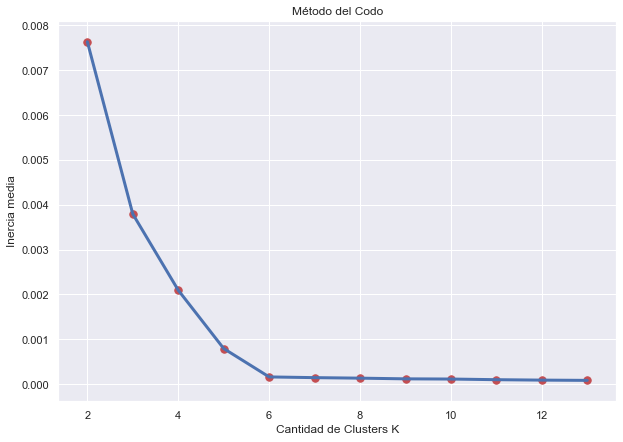

In [44]:
plt.figure(figsize = (10,7))
# Graficamos una linea continua y tambien unos puntos para resaltar los valores enteros de K.
plt.plot(K, lista_distancias_medias, lw=3)
plt.scatter(K, lista_distancias_medias, s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Inercia media')
plt.title('Método del Codo')

plt.show()

* *Se busca el mejor numero de k en cada caso según la curva y se grafican los clusters para cada dataset.*
* *El número óptimo se encuentra cuando la curva detiene la caída abrupta y empieza a disminuir lentamente.*

C:\Users\Ale\anaconda3\envs\ds\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ale\anaconda3\envs\ds\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


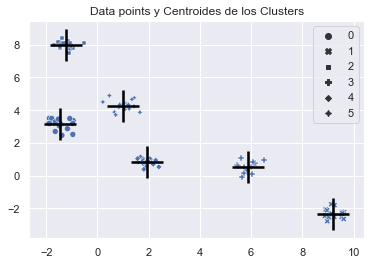

In [45]:
# Defino y entreno el modelo
km = KMeans(n_clusters=6)
km = km.fit(X)

# Obtengo la posición de los centros y las etiquetas
etiquetas_ = km.labels_
centros_ = km.cluster_centers_

# Graficamos los centros de los clusters y los datapoints
sns.scatterplot(X[:, 0], X[:, -1], style = etiquetas_)
sns.scatterplot(centros_[:, 0], centros_[:, 1],color='black', marker="+", s=1000)
plt.title('Data points y Centroides de los Clusters')
plt.show()

* *S/ el gráfico, parecería que el **n_clusters** más acorde sería de **6**.*

### 6. Conclusion

In this kernel we have tried to do fraud detection on a bank payment data and we have achieved remarkable results with our classifiers. Since fraud datasets have an imbalance class problem we performed an oversampling technique called SMOTE and generated new minority class examples. I haven't put the classification results without SMOTE here but i added them in my github repo before so if you are interested to compare both results you can also check my github repo.

Thanks for taking the time to read or just view the results from my first kernel i hope you enjoyed it. I would be grateful for any kind of critique, suggestion or comment and i wish you to have a great day with lots of beautiful data!

### 7. Resources

[1]. Lavion, Didier; et al. "PwC's Global Economic Crime and Fraud Survey 2018" (PDF). PwC.com. Retrieved 28 August 2018.

[2]. SMOTE: Synthetic Minority Over-sampling Technique.